# RVOL/ROC Filter Verification

This notebook verifies the RVOL/ROC filtering logic on CYPH data for 2025-11-14.

**Pipeline Steps:**
1. Download 1-second OHLCV data for CYPH
2. Resample to 10-second bars
3. Calculate RVOL (Relative Volume)
4. Calculate ROC (Rate of Change)
5. Check if any bar meets criteria: RVOL > 10 AND ROC > 10%
6. Visualize results

In [5]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Add pipeline to path
sys.path.insert(0, '../scripts')

from pipeline.config import Config
from pipeline.fetchers import DatabentoFetcher
from pipeline.utils.relativevolume import relative_volume
from pipeline.utils.roc import roc

# Configure plotting
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)

print("✓ Imports successful")
print(f"RVOL Threshold: {Config.RVOL_THRESHOLD}")
print(f"ROC Threshold: {Config.ROC_THRESHOLD}%")
print(f"Resample Interval: {Config.OHLCV_RESAMPLE_INTERVAL}")

✓ Imports successful
RVOL Threshold: 10.0
ROC Threshold: 10.0%
Resample Interval: 10s


## Step 1: Download 1-Second OHLCV Data for CYPH

In [6]:
# Configuration
SYMBOL = 'CYPH'
DATE = '2025-11-14'

print(f"Downloading 1-second OHLCV data for {SYMBOL} on {DATE}...")

# Initialize fetcher
fetcher = DatabentoFetcher("db-pduLct3LCjymtVsMBMbVPSfY9QaBA")

# Fetch 1-second data
df_1s = fetcher.fetch_ohlcv_1s_batch([SYMBOL], DATE)

print(f"\n✓ Downloaded {len(df_1s):,} 1-second bars")
print(f"\nDataFrame Info:")
print(f"  Columns: {list(df_1s.columns)}")
print(f"  Index: {df_1s.index.name}")
print(f"  Shape: {df_1s.shape}")
print(f"\nFirst few rows:")
df_1s.head()


Fetching 1-Second OHLCV Data (Batch)

Symbols: 1
Date: 2025-11-14
Dataset: XNAS.ITCH
[SUCCESS] Received 8,916 bars (1 symbols)

✓ Downloaded 8,916 1-second bars

DataFrame Info:
  Columns: ['rtype', 'publisher_id', 'instrument_id', 'open', 'high', 'low', 'close', 'volume', 'symbol']
  Index: ts_event
  Shape: (8916, 9)

First few rows:


,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
ts_event,,,,,,,,,
2025-11-14 09:03:42+00:00,32,2,21981,1.72,1.72,1.72,1.72,300,CYPH
2025-11-14 09:03:44+00:00,32,2,21981,1.72,1.72,1.72,1.72,500,CYPH
2025-11-14 09:04:14+00:00,32,2,21981,1.71,1.71,1.71,1.71,1263,CYPH
2025-11-14 09:04:17+00:00,32,2,21981,1.71,1.71,1.71,1.71,50,CYPH
2025-11-14 09:04:19+00:00,32,2,21981,1.71,1.71,1.71,1.71,20,CYPH


## Step 2: Resample to 10-Second Bars

In [7]:
def resample_to_10s(df_1s, symbol, resample_interval='10s'):
    """
    Resample 1-second OHLCV data to 10-second bars.
    """
    df = df_1s.copy()
    
    # Databento returns data with timestamp as index
    if df.index.name == 'ts_event' or 'ts_event' not in df.columns:
        df = df.reset_index()
    
    # Ensure ts_event is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['ts_event']):
        df['ts_event'] = pd.to_datetime(df['ts_event'])
    
    # Filter for symbol
    if 'symbol' in df.columns:
        df = df[df['symbol'] == symbol].copy()
    
    # Set index and resample
    df = df.set_index('ts_event')
    
    # Resample using OHLC rules
    resampled = df.resample(resample_interval).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    })
    
    # Drop empty bars
    resampled = resampled.dropna(subset=['close'])
    
    return resampled

# Resample to 10-second bars
df_10s = resample_to_10s(df_1s, SYMBOL, Config.OHLCV_RESAMPLE_INTERVAL)

print(f"✓ Resampled to {len(df_10s):,} 10-second bars")
print(f"\nTime range: {df_10s.index[0]} to {df_10s.index[-1]}")
print(f"\nFirst few 10-second bars:")
df_10s.head(10)

✓ Resampled to 2,659 10-second bars

Time range: 2025-11-14 09:03:40+00:00 to 2025-11-14 23:58:10+00:00

First few 10-second bars:


,open,high,low,close,volume
ts_event,,,,,
2025-11-14 09:03:40+00:00,1.72,1.72,1.72,1.72,800
2025-11-14 09:04:10+00:00,1.71,1.71,1.71,1.71,1333
2025-11-14 09:04:20+00:00,1.71,1.71,1.71,1.71,28
2025-11-14 09:08:00+00:00,1.71,1.71,1.71,1.71,686
2025-11-14 09:08:10+00:00,1.70,1.70,1.70,1.70,1
2025-11-14 09:14:00+00:00,1.71,1.71,1.71,1.71,1008
2025-11-14 09:19:30+00:00,1.74,1.74,1.74,1.74,1892
2025-11-14 09:19:40+00:00,1.74,1.74,1.74,1.74,1356
2025-11-14 09:20:00+00:00,1.75,1.75,1.75,1.75,2450


## Step 3: Calculate RVOL (Relative Volume)

In [17]:
# Calculate RVOL using the pipeline utility
# Note: DataFrame must have DatetimeIndex
print("Calculating RVOL...")
print(f"  Length: {Config.RVOL_LENGTH}")
print(f"  isCumulative: False")

curr_vol, hist_vol, rvol_ratio = relative_volume(
    df_10s,
    length=Config.RVOL_LENGTH,
    anchorTimeframe='5',
    isCumulative=False,
    adjustRealtime=False
)

df_10s['rvol'] = rvol_ratio
df_10s['curr_vol'] = curr_vol
df_10s['hist_vol'] = hist_vol

print(f"\n✓ RVOL calculated")
print(f"\nRVOL Statistics:")
print(df_10s['rvol'].describe())

# Show bars with highest RVOL
print(f"\nTop 10 bars by RVOL:")
df_10s.nlargest(10, 'rvol')[['open', 'high', 'low', 'close', 'volume', 'rvol']]

Calculating RVOL...
  Length: 10
  isCumulative: False

✓ RVOL calculated

RVOL Statistics:
count    2656.000000
mean        1.827020
std         6.498232
min         0.000051
25%         0.129228
50%         0.463430
75%         1.541738
max       166.678284
Name: rvol, dtype: float64

Top 10 bars by RVOL:


,open,high,low,close,volume,rvol
ts_event,,,,,,
2025-11-14 21:00:00+00:00,2.75,2.750,2.66,2.660,229566,166.678284
2025-11-14 14:30:00+00:00,2.07,2.070,2.06,2.060,144896,159.191387
2025-11-14 14:42:20+00:00,2.15,2.400,2.15,2.380,159417,118.905795
2025-11-14 14:36:50+00:00,2.17,2.240,2.17,2.240,39761,82.066047
2025-11-14 20:59:50+00:00,2.70,2.760,2.66,2.750,111318,69.743750
2025-11-14 13:45:50+00:00,1.90,1.910,1.90,1.900,59972,58.934748
2025-11-14 20:41:50+00:00,2.61,2.615,2.58,2.585,139849,51.384847
2025-11-14 14:45:50+00:00,2.38,2.440,2.38,2.440,92095,43.804699
2025-11-14 14:49:20+00:00,2.50,2.530,2.48,2.510,142035,38.548282


## Step 4: Calculate ROC (Rate of Change)

In [18]:
# Calculate ROC using the pipeline utility
print("Calculating ROC...")
print(f"  Length: {Config.ROC_LENGTH}")

df_10s['roc'] = roc(df_10s['close'], length=Config.ROC_LENGTH)

print(f"\n✓ ROC calculated")
print(f"\nROC Statistics:")
print(df_10s['roc'].describe())

# Show bars with highest ROC
print(f"\nTop 10 bars by ROC:")
df_10s.nlargest(10, 'roc')[['open', 'high', 'low', 'close', 'volume', 'roc']]

Calculating ROC...
  Length: 9

✓ ROC calculated

ROC Statistics:
count    2650.000000
mean        0.181420
std         2.464455
min       -10.447761
25%        -1.374576
50%         0.000000
75%         1.469988
max        12.565445
Name: roc, dtype: float64

Top 10 bars by ROC:


,open,high,low,close,volume,roc
ts_event,,,,,,
2025-11-14 14:35:00+00:00,2.12,2.15,2.11,2.15,25342,12.565445
2025-11-14 13:07:10+00:00,2.09,2.16,2.09,2.11,9936,11.640212
2025-11-14 13:06:00+00:00,1.93,1.98,1.93,1.98,1608,11.235955
2025-11-14 17:10:10+00:00,3.39,3.46,3.39,3.46,97396,11.075441
2025-11-14 14:35:10+00:00,2.16,2.16,2.13,2.13,17248,10.937500
2025-11-14 17:10:20+00:00,3.47,3.50,3.44,3.44,29241,10.610932
2025-11-14 17:10:30+00:00,3.44,3.47,3.43,3.44,18957,10.610932
2025-11-14 13:07:00+00:00,2.05,2.10,2.02,2.10,5548,10.526316
2025-11-14 13:05:50+00:00,1.93,1.93,1.93,1.93,5600,10.285714


## Step 5: Check Filter Criteria

Session passes if **ANY** bar has **BOTH** `RVOL ≥ 10` **AND** `ROC ≥ 10%`

In [19]:
# Drop rows with NaN values
df_analysis = df_10s.dropna(subset=['rvol', 'roc']).copy()

print(f"Bars with valid RVOL/ROC data: {len(df_analysis):,}")
print(f"\nFilter Criteria:")
print(f"  RVOL threshold: {Config.RVOL_THRESHOLD}")
print(f"  ROC threshold: {Config.ROC_THRESHOLD}%")

# Find bars that meet criteria
passed_rvol = df_analysis['rvol'] >= Config.RVOL_THRESHOLD
passed_roc = df_analysis['roc'] >= Config.ROC_THRESHOLD
passed_both = passed_rvol & passed_roc

print(f"\nResults:")
print(f"  Bars with RVOL ≥ {Config.RVOL_THRESHOLD}: {passed_rvol.sum()}")
print(f"  Bars with ROC ≥ {Config.ROC_THRESHOLD}%: {passed_roc.sum()}")
print(f"  Bars with BOTH criteria met: {passed_both.sum()}")

# Session passes?
session_passes = passed_both.sum() > 0
print(f"\n{'✓' if session_passes else '✗'} Session {'PASSES' if session_passes else 'FAILS'} RVOL/ROC filter")

if passed_both.sum() > 0:
    print(f"\nBars that passed BOTH criteria:")
    passed_bars = df_analysis[passed_both].copy()
    passed_bars = passed_bars.reset_index()
    display(passed_bars[['ts_event', 'open', 'high', 'low', 'close', 'volume', 'rvol', 'roc']])
    
    # Show the first passing bar (what would be recorded)
    best_bar = passed_bars.iloc[0]
    print(f"\nFirst passing bar (recorded in pipeline):")
    print(f"  Timestamp: {best_bar['ts_event']}")
    print(f"  RVOL: {best_bar['rvol']:.2f}")
    print(f"  ROC: {best_bar['roc']:.2f}%")
    print(f"  Price: ${best_bar['close']:.4f}")
    print(f"  Volume: {int(best_bar['volume']):,}")
else:
    print(f"\n⚠️ No bars met both criteria")
    
    # Show closest bars
    print(f"\nClosest bars to meeting criteria:")
    df_analysis['score'] = df_analysis['rvol'] + df_analysis['roc']
    top_bars = df_analysis.nlargest(5, 'score').reset_index()
    display(top_bars[['ts_event', 'close', 'volume', 'rvol', 'roc', 'score']])

Bars with valid RVOL/ROC data: 2,650

Filter Criteria:
  RVOL threshold: 10.0
  ROC threshold: 10.0%

Results:
  Bars with RVOL ≥ 10.0: 75
  Bars with ROC ≥ 10.0%: 11
  Bars with BOTH criteria met: 3

✓ Session PASSES RVOL/ROC filter

Bars that passed BOTH criteria:


,ts_event,open,high,low,close,volume,rvol,roc
0,2025-11-14 13:07:10+00:00,2.09,2.16,2.09,2.11,9936,15.279102,11.640212
1,2025-11-14 14:35:10+00:00,2.16,2.16,2.13,2.13,17248,18.540256,10.937500
2,2025-11-14 14:42:20+00:00,2.15,2.40,2.15,2.38,159417,118.905795,10.185185



First passing bar (recorded in pipeline):
  Timestamp: 2025-11-14 13:07:10+00:00
  RVOL: 15.28
  ROC: 11.64%
  Price: $2.1100
  Volume: 9,936


## Step 6: Visualize Results

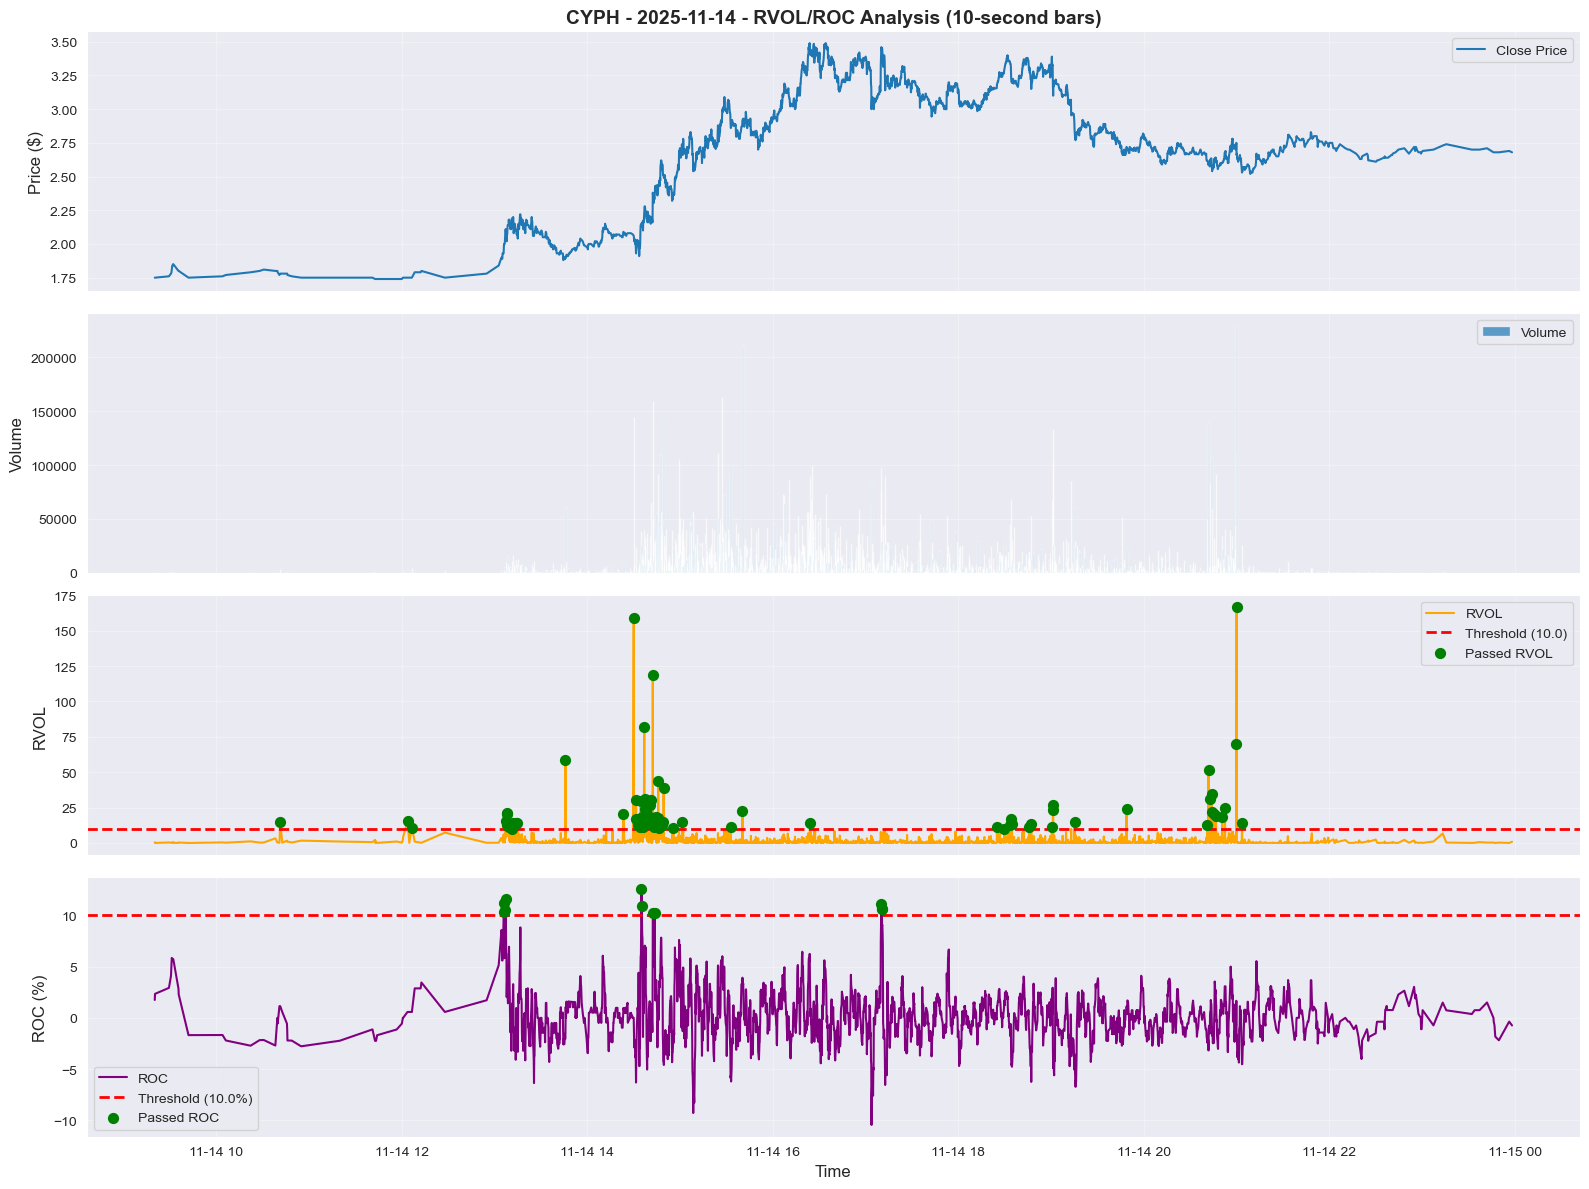


VERIFICATION COMPLETE
Symbol: CYPH
Date: 2025-11-14
Result: PASS ✓


In [20]:
# Create comprehensive visualization
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

df_plot = df_analysis.reset_index()

# 1. Price chart
ax1 = axes[0]
ax1.plot(df_plot['ts_event'], df_plot['close'], label='Close Price', linewidth=1.5)
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.set_title(f'{SYMBOL} - {DATE} - RVOL/ROC Analysis (10-second bars)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Volume chart
ax2 = axes[1]
ax2.bar(df_plot['ts_event'], df_plot['volume'], width=0.0001, alpha=0.7, label='Volume')
ax2.set_ylabel('Volume', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. RVOL chart
ax3 = axes[2]
ax3.plot(df_plot['ts_event'], df_plot['rvol'], label='RVOL', linewidth=1.5, color='orange')
ax3.axhline(y=Config.RVOL_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({Config.RVOL_THRESHOLD})')
if passed_rvol.sum() > 0:
    passed_rvol_data = df_plot[df_plot['rvol'] >= Config.RVOL_THRESHOLD]
    ax3.scatter(passed_rvol_data['ts_event'], passed_rvol_data['rvol'], 
                color='green', s=50, zorder=5, label='Passed RVOL')
ax3.set_ylabel('RVOL', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. ROC chart
ax4 = axes[3]
ax4.plot(df_plot['ts_event'], df_plot['roc'], label='ROC', linewidth=1.5, color='purple')
ax4.axhline(y=Config.ROC_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({Config.ROC_THRESHOLD}%)')
if passed_roc.sum() > 0:
    passed_roc_data = df_plot[df_plot['roc'] >= Config.ROC_THRESHOLD]
    ax4.scatter(passed_roc_data['ts_event'], passed_roc_data['roc'], 
                color='green', s=50, zorder=5, label='Passed ROC')
ax4.set_xlabel('Time', fontsize=12)
ax4.set_ylabel('ROC (%)', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Highlight bars that passed BOTH criteria
if passed_both.sum() > 0:
    passed_both_data = df_plot[df_plot.index.isin(df_analysis[passed_both].index)]
    for ax in axes:
        for ts in passed_both_data['ts_event']:
            ax.axvline(x=ts, color='green', alpha=0.3, linewidth=2)

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print(f"VERIFICATION COMPLETE")
print(f"{'='*80}")
print(f"Symbol: {SYMBOL}")
print(f"Date: {DATE}")
print(f"Result: {'PASS ✓' if session_passes else 'FAIL ✗'}")
print(f"{'='*80}")

## Additional Analysis: Distribution of RVOL and ROC

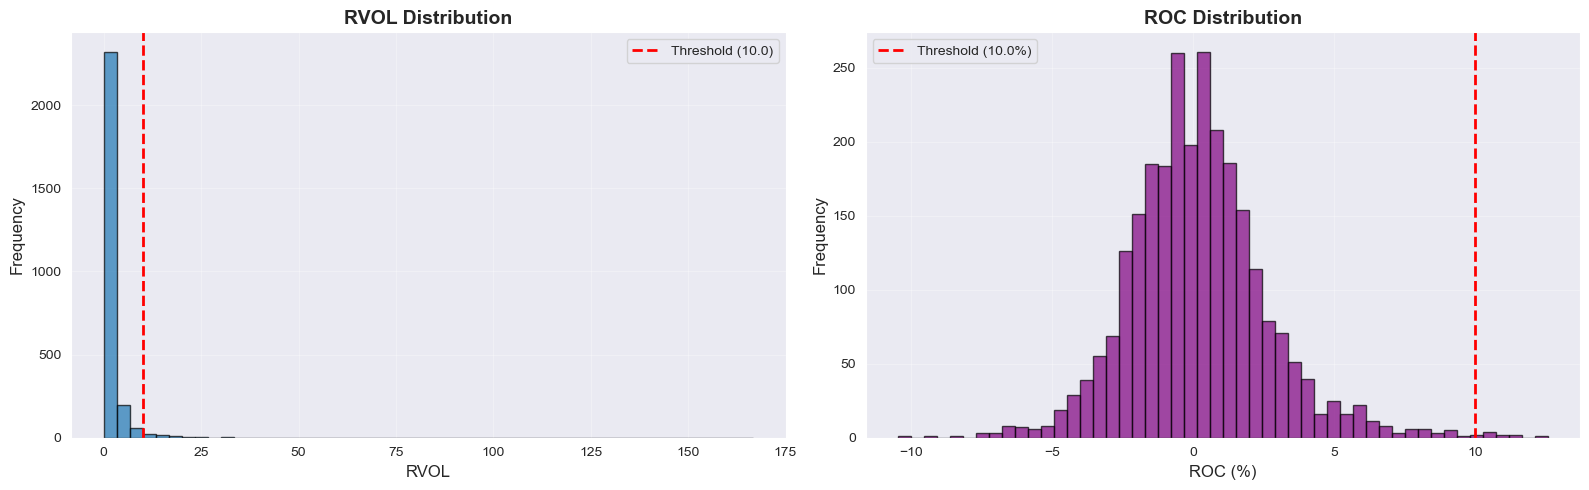


Summary Statistics:

RVOL:
  Max: 166.68
  95th percentile: 6.74
  Median: 0.46
  Bars ≥ threshold: 75 (2.8%)

ROC:
  Max: 12.57%
  95th percentile: 4.28%
  Median: 0.00%
  Bars ≥ threshold: 11 (0.4%)


In [21]:
# Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# RVOL distribution
ax1 = axes[0]
df_analysis['rvol'].hist(bins=50, ax=ax1, edgecolor='black', alpha=0.7)
ax1.axvline(x=Config.RVOL_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({Config.RVOL_THRESHOLD})')
ax1.set_xlabel('RVOL', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('RVOL Distribution', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ROC distribution
ax2 = axes[1]
df_analysis['roc'].hist(bins=50, ax=ax2, edgecolor='black', alpha=0.7, color='purple')
ax2.axvline(x=Config.ROC_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({Config.ROC_THRESHOLD}%)')
ax2.set_xlabel('ROC (%)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('ROC Distribution', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nSummary Statistics:")
print(f"\nRVOL:")
print(f"  Max: {df_analysis['rvol'].max():.2f}")
print(f"  95th percentile: {df_analysis['rvol'].quantile(0.95):.2f}")
print(f"  Median: {df_analysis['rvol'].median():.2f}")
print(f"  Bars ≥ threshold: {passed_rvol.sum()} ({100*passed_rvol.sum()/len(df_analysis):.1f}%)")

print(f"\nROC:")
print(f"  Max: {df_analysis['roc'].max():.2f}%")
print(f"  95th percentile: {df_analysis['roc'].quantile(0.95):.2f}%")
print(f"  Median: {df_analysis['roc'].median():.2f}%")
print(f"  Bars ≥ threshold: {passed_roc.sum()} ({100*passed_roc.sum()/len(df_analysis):.1f}%)")

## Threshold Sensitivity Analysis

Test different threshold combinations to understand filtering behavior

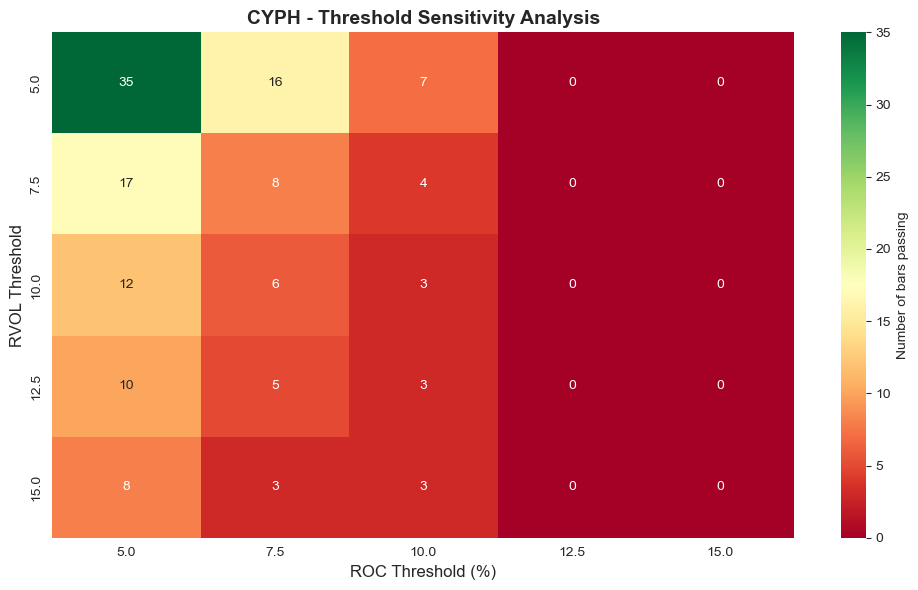


Current pipeline thresholds: RVOL=10.0, ROC=10.0%
Bars passing with current thresholds: 3
Session passes: True


In [22]:
# Test different threshold combinations
rvol_thresholds = [5, 7.5, 10, 12.5, 15]
roc_thresholds = [5, 7.5, 10, 12.5, 15]

results = []
for rvol_thresh in rvol_thresholds:
    for roc_thresh in roc_thresholds:
        passed = ((df_analysis['rvol'] >= rvol_thresh) & 
                  (df_analysis['roc'] >= roc_thresh)).sum()
        results.append({
            'RVOL_Threshold': rvol_thresh,
            'ROC_Threshold': roc_thresh,
            'Bars_Passed': passed,
            'Session_Passes': passed > 0
        })

df_sensitivity = pd.DataFrame(results)
pivot = df_sensitivity.pivot(index='RVOL_Threshold', columns='ROC_Threshold', values='Bars_Passed')

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='RdYlGn', cbar_kws={'label': 'Number of bars passing'})
plt.title(f'{SYMBOL} - Threshold Sensitivity Analysis', fontsize=14, fontweight='bold')
plt.xlabel('ROC Threshold (%)', fontsize=12)
plt.ylabel('RVOL Threshold', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nCurrent pipeline thresholds: RVOL={Config.RVOL_THRESHOLD}, ROC={Config.ROC_THRESHOLD}%")
current_result = df_sensitivity[
    (df_sensitivity['RVOL_Threshold'] == Config.RVOL_THRESHOLD) & 
    (df_sensitivity['ROC_Threshold'] == Config.ROC_THRESHOLD)
]
if not current_result.empty:
    print(f"Bars passing with current thresholds: {int(current_result['Bars_Passed'].iloc[0])}")
    print(f"Session passes: {current_result['Session_Passes'].iloc[0]}")